<a href="https://colab.research.google.com/github/AbeerBibi/Prediction-of-Product-Sales/blob/main/Project_1_Part_6_(Core).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project 1 - Part 6 (Core):
This week, you will add modeling to your sales prediction project. The goal of this is to help the retailer understand the properties of products and outlets that play crucial roles in predicting sales



---



#Import libraries, call evaluation function, load the data

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor # NEW
from sklearn import set_config
from sklearn.ensemble import BaggingRegressor
set_config(transform_output='pandas')

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics
def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )
  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)

In [ ]:
# Load data directly from url
df = pd.read_csv('/content/drive/MyDrive/CodingDojo/02-IntroML/Week05/Data/sales_predictions_2023.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
# check for null values
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [ ]:
#check the inconsistencies in the categorical columns
for column in df.select_dtypes(include='object').columns:
    print(column, df[column].unique())

Item_Identifier ['FDA15' 'DRC01' 'FDN15' ... 'NCF55' 'NCW30' 'NCW05']
Item_Fat_Content ['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
Item_Type ['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
Outlet_Identifier ['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']
Outlet_Size ['Medium' nan 'High' 'Small']
Outlet_Location_Type ['Tier 1' 'Tier 3' 'Tier 2']
Outlet_Type ['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']


In [ ]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'})

#CRISP-DM Phase 4 - Modeling

##1. Your first task is to build a linear regression model to predict sales.

###Build a linear regression model.

In [ ]:
## Separate features vs target & train/test split
X = df.drop(columns=['Item_Outlet_Sales', 'Item_Identifier'])
y = df['Item_Outlet_Sales']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,16.350,Low Fat,0.029565,Household,256.4646,OUT018,2009,Medium,Tier 3,Supermarket Type2
7510,15.250,Regular,0.000000,Snack Foods,179.7660,OUT018,2009,Medium,Tier 3,Supermarket Type2
5828,12.350,Regular,0.158716,Meat,157.2946,OUT049,1999,Medium,Tier 1,Supermarket Type1
5327,7.975,Low Fat,0.014628,Baking Goods,82.3250,OUT035,2004,Small,Tier 2,Supermarket Type1
4810,19.350,Low Fat,0.016645,Frozen Foods,120.9098,OUT045,2002,NaN,Tier 2,Supermarket Type1


In [ ]:
# Numeric
num_cols = X_train.select_dtypes("number").columns
impute_mean = SimpleImputer(strategy='mean')
scaler = StandardScaler()
num_pipe = make_pipeline(impute_mean, scaler)
num_tuple = ('numeric', num_pipe, num_cols)
# Ordinal
ordinal_cols=['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type']
impute_na_ord = SimpleImputer(strategy='constant', fill_value='NA')
ordinals_order_fat_content= ['Low Fat', 'Regular']
ordinals_order_outlet_size=['NA', 'Small', 'Medium', 'High']
ordinals_order_outlet_location_type=['Tier 1', 'Tier 2', 'Tier 3']
ordinal_category_orders=[ordinals_order_fat_content, ordinals_order_outlet_size, ordinals_order_outlet_location_type]
ord_encoder = OrdinalEncoder(categories=ordinal_category_orders)
scaler_ord = StandardScaler()
ord_pipe = make_pipeline(impute_na_ord, ord_encoder, scaler_ord)
ord_tuple = ('ordinal', ord_pipe, ordinal_cols)
# Nominal
ohe_cols = X_train.select_dtypes('object').drop(columns=ordinal_cols).columns
impute_na = SimpleImputer(strategy='constant', fill_value="NA")
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe_pipe = make_pipeline(impute_na, ohe_encoder)
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)

In [ ]:
 # Instantiate with verbose_feature_names_out=False
preprocessor = ColumnTransformer([num_tuple, ord_tuple, ohe_tuple], verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('ordinalencoder',
                                                  OrdinalEn...
                                                  StandardScaler())]),
                                 ['Item_Fat_Content', 'Outlet_Size',
                                  'Outlet_Location_Type']),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Item_Type', 'Outlet_Identifier', 'Outlet_Type'], dtype='object'))],
                  verbose_feature_names_out=False)

In [ ]:
# Instantiate a linear regression model
linreg = LinearRegression()
# Combine the preprocessing ColumnTransformer and the linear regression model in a Pipeline
linreg_pipe = make_pipeline(preprocessor, linreg)
linreg_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='co...
                                                   'Outlet_Location_Type']),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Item_Type', 'Outlet_Identifier', 'Outlet_Type'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('linearregression', LinearRegression())])

In [ ]:
# Fit the model pipeline on the training data
linreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='co...
                                                   'Outlet_Location_Type']),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Item_Type', 'Outlet_Identifier', 'Outlet_Type'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('linearregression', LinearRegression())])

###Use the custom evaluation function to get the metrics for your model (on training and test data).

In [ ]:
# Obtain Model Evulation using custom function
evaluate_regression(linreg_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 847.129
- MSE = 1,297,558.136
- RMSE = 1,139.104
- R^2 = 0.562

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 804.120
- MSE = 1,194,349.715
- RMSE = 1,092.863
- R^2 = 0.567


###Compare the training vs. test R-squared values and answer the question: to what extent is this model overfit/underfit?

The training R^2 value is 0.562, while the testing R^2 value is 0.567.

Since the testing R^2 value is slightly higher than the training R^2 value, it suggests that the model is not overfitting the training data. Instead, it indicates that the model is generalizing well to new, unseen data.

##2. Your second task is to build a Random Forest model to predict sales.

###Build a default Random Forest model.

In [ ]:
# Instantiate default random forest model
rf = RandomForestRegressor(random_state = 42)
# Model Pipeline
rf_pipe = make_pipeline(preprocessor, rf)
# Fit the model pipeline on the training data only
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='co...
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Item_Type', 'Outlet_Identifier', 'Outlet_Type'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

###Use the custom evaluation function to get the metrics for your model (on training and test data).

In [ ]:
# Use custom function to evaluate default model
evaluate_regression(rf_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 296.392
- MSE = 182,583.136
- RMSE = 427.297
- R^2 = 0.938

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 767.390
- MSE = 1,219,078.737
- RMSE = 1,104.119
- R^2 = 0.558


###Compare the training vs. test R-squared values and answer the question: to what extent is this model overfit/underfit?

Such a large discrepancy between the training and testing R^2 values suggests that the model is overfitting the training data.

An R^2 value of 0.938 for the training set indicates that the model explains about 93.8% of the variance in the training data, which is remarkably high. However, the R^2 value of 0.558 for the testing set indicates that the model only explains about 55.8% of the variance in the testing data. This drop in performance on unseen data is indicative of overfitting.

###Compare this model's performance to the linear regression model: which model has the best test scores?

- The linear regression model demonstrated balanced performance with minimal overfitting, the random forest model exhibits clear signs of overfitting due to the considerable disparity between training and testing R^2 values.

- Based on the testing R^2 scores alone, the linear regression model has the better test score than the random forest model.

However, when evaluating model performance, it's crucial to consider both training and testing performance.

##3. Use GridSearchCV to tune at least two hyperparameters for a Random Forest model.

###After determining the best parameters from your GridSearch, fit and evaluate a final best model on the entire training set (no folds).

In [ ]:
# Define param grid with options to try
params = {'randomforestregressor__max_depth': [None,10,15,20],
          'randomforestregressor__n_estimators':[10,100,150,200],
          'randomforestregressor__min_samples_leaf':[2,3,4],
          'randomforestregressor__max_features':['sqrt','log2',None],
          'randomforestregressor__oob_score':[True,False],
          }

# Instantiate the gridsearch
gridsearch = GridSearchCV(rf_pipe, params, n_jobs=-1, cv = 3, verbose=1)
# Fit the gridsearch on training data
gridsearch.fit(X_train, y_train)
# Define and refit best model
best_rf = gridsearch.best_estimator_
#evaluate
evaluate_regression(best_rf, X_train, y_train, X_test, y_test)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 653.645
- MSE = 869,292.769
- RMSE = 932.359
- R^2 = 0.706

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 734.654
- MSE = 1,119,440.614
- RMSE = 1,058.036
- R^2 = 0.594


###Compare your tuned model to your default Random Forest: did the performance improve?

- Training Performance:

 - The default Random Forest model had a higher training R^2 value (0.938) compared to the tuned model (0.706). This suggests that the default model was better at capturing the variability in the training data.

- Testing Performance:

 - However, when it comes to testing performance, the tuned Random Forest model outperformed the default model. The tuned model achieved a higher testing R^2 value (0.594) compared to the default model (0.558). This indicates that the tuned model generalizes better to new, unseen data.

The performance of the Random Forest model improved after tuning, especially in terms of testing performance. While the training performance decreased slightly, the improvement in testing performance suggests that the tuned model is better suited for making predictions on new data.

#CRISP-DM Phase 5 - Evaluation

##4. You now have tried several different models on your data set. You need to determine which model to implement.

- Overall, which model do you recommend?
- Justify your recommendation.
- Interpret your model's performance based on R-squared in a way that your non-technical stakeholder can understand.



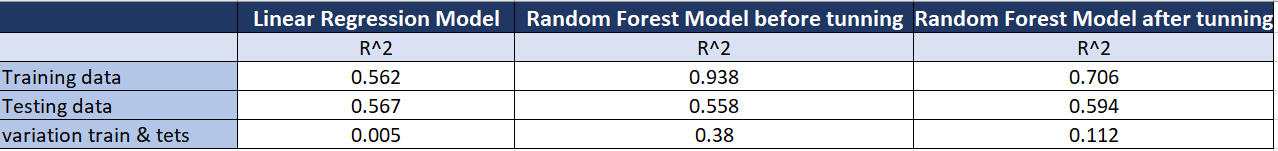


Overall, I recommend the tuned Random Forest model since it achieves the highest R^2 value and maintains a relatively small difference between training and testing data (0.112). This difference is significantly smaller compared to the same model before tuning (0.38). Although the linear regression model shows less variation between training and testing data, it has a lower R^2 value.

For stakeholders' understanding, R^2 represents the proportion of the variance in the target variable (e.g., Item_Outlet_Sales) explained by the model. With an R^2 value of 0.594, the tuned Random Forest model explains approximately 59% of the variability in the predicted variable. Stakeholders can expect this model's predictions (tunned Random Forest model) to be closer to the true values compared to other models with lower
R^2 values, capturing over 59% of the variability in prices.



---



- Select another regression metric (RMSE/MAE/MSE) to express the performance of your model to your stakeholder.
- Include why you selected this metric to explain to your stakeholder.
- Compare the training vs. test scores and answer the question: to what extent is this model overfit/underfit?

**I select RMSE:**



---

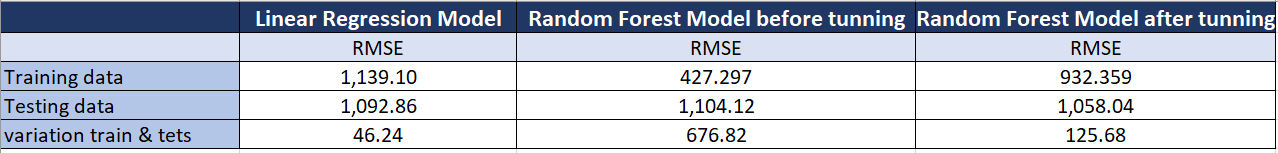

- For non-technical stakeholders, an RMSE value of 1058.04 (Tunned Random Forest Model) for predicting Item_Outlet_Sales means that, on average, our model's predictions differ from the actual sales values by approximately 1058.04 dollars. In simpler terms, it suggests that our model's predictions may be off by around 1058.04 dollars when estimating the sales of an outlet.

- In comparing models, we use RMSE (Root Mean Squared Error) to assess how close the model's predictions are to the true values. A lower RMSE indicates better predictive accuracy. Our tuned random forest model achieved the lowest RMSE of 1058.04 for predicting Item_Outlet_Sales, suggesting it provides the closest predictions to the true values compared to other models. Although it showed a higher variation between training and testing data (125.68) compared to linear regression (46.24), its overall RMSE was still lower (1058.04 vs. 1092.86). Therefore, despite the variation, the tuned random forest model remains the better choice for predicting Item_Outlet_Sales.